In [225]:
import pandas as pd
import numpy as np
import math as mt
from statsmodels.tsa.api import ExponentialSmoothing
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import seaborn as sns
sns.set()

# Metrics ans Baseline

Metrics:

A percentage error makes no sense when measuring the accuracy of temperature forecasts on Celsius scales, because temperature has an arbitrary zero point. Therefore, we will use the average error (bias) to look at the overall direction of the forecast, and to mesure the precision of the forecast, we will use the mean absolute error (MAE) and root mean squared error (RMSE).

In [214]:
#func to return a df with all our metrics

def metrics(serie_true,serie_pred,model_name ='Model'):
    err = [v_true - v_false for v_true,v_false in zip(serie_true,serie_pred)]
    absolute_err = [abs(i) for i in err]
    bias = np.mean(err)
    mae = np.mean(absolute_err) 
    rmse = mt.sqrt(mean_squared_error(serie_true, serie_pred)) 
    
    metrics_df = pd.DataFrame({'Bias':bias,'MAE':mae,'RMSE':rmse},index =[model_name])
    metrics_df.index.name = 'Model'
    return metrics_df

For the baseline we will use the naïve forecast (set all forecasts to be the value of the last observation). 

This method makes a lot of sense considering the nature of the time series (measures of the minimum daily temperature) and also considering our autocorrelation analysis (presented in the 'time_series_analysis' file) in which we see a high correlation for one day of lag (pearson number = 0.774 )

In [215]:
# loadin our pre-treated df 

min_temp_df = pd.read_csv('daily-minimum-temperatures-in-me-treated.csv')
min_temp_df.head(3)

,date,daily_min_temp
0,1981-01-01,20.7
1,1981-01-02,17.9
2,1981-01-03,18.8


In [216]:
#naïve forecast

min_temp_df_naive = min_temp_df.copy()
min_temp_df_naive['naive_forecast'] = min_temp_df['daily_min_temp'].shift(1)
min_temp_df_naive.dropna(inplace = True) #droping firt record
min_temp_df_naive.reset_index(drop= True,inplace = True)

min_temp_df_naive.tail()

,date,daily_min_temp,naive_forecast
3644,1990-12-27,14.0,14.6
3645,1990-12-28,13.6,14.0
3646,1990-12-29,13.5,13.6
3647,1990-12-30,15.7,13.5
3648,1990-12-31,13.0,15.7


In [217]:
#naïve metrics

naive_metrics = metrics(min_temp_df_naive.daily_min_temp,min_temp_df_naive.naive_forecast,'naïve')

naive_metrics

,Bias,MAE,RMSE
Model,,,
naïve,-0.00211,2.133817,2.731584


The naïve forecast may be a very simple method, but in this case it offers a very good result, low error and no bias. Sometimes simple is better.

It will be very interesting to see if we can improve these results with more complex methods!

# Holt-Winters Forecast

As we saw in the time serie analysis, our data have a very high seasonality and no trend. Therefore, it makes sense to choose a model that accepts an additive seasonality (frequency remains constant). 

In [218]:
#initial preparation
min_temp_df2 = min_temp_df.copy()

#set date to index and to datetime type 
min_temp_df2.date = pd.to_datetime(min_temp_df2.date, format="%Y/%m/%d") 
min_temp_df2.set_index('date',inplace = True)

# Set the frequency of the date time index as daily 
min_temp_df2 = min_temp_df2.asfreq('D')

#note that the above code may create nan values if there are missing dates

In [219]:
min_temp_df2[pd.isnull(min_temp_df2.daily_min_temp)]

,daily_min_temp
date,
1984-12-31,NaN
1988-12-31,NaN


We have two unregistered dates, we can fill them with the values of the previous day without compromising the dataset

In [220]:
min_temp_df2.fillna(method='ffill',inplace = True)
min_temp_df2['1984-12-29':'1985-01-02']

,daily_min_temp
date,
1984-12-29,16.0
1984-12-30,16.4
1984-12-31,16.4
1985-01-01,13.3
1985-01-02,15.2


To evaluate the Holt-Winters model we will forecast day min temperature for each record (in exception for the first year, since we will not have a complete seasonal cycle)

To do this correctly, we will train the model only with the data collected before the forecast date. That is, we will train a model for each forecast, dropping the previous data.

In [221]:
def hot_winters_seasonal_add(df):
    date_forecast, forecast,true_value = [[] for i in range(3)]
    
    for n in range(1,len(df)-365):
        train_df = df.drop(df.tail(n).index) #drop n last values to fit the model with right data
        model = ExponentialSmoothing(train_df, seasonal_periods=12, seasonal='add').fit()
        forecast_result = model.forecast(1)
        
        forecast.append(forecast_result.values[0])
        true_value.append(df.daily_min_temp[len(df)-n])
        date_forecast.append(df.index[len(df)-n])
        
    forecast_df = pd.DataFrame({'daily_min_temp':true_value,'forecast':forecast},index =date_forecast)
    forecast_df= forecast_df.iloc[::-1] #reverse df to keep dates in chronological order
    return forecast_df

In [222]:
hot_winters_forecast = hot_winters_seasonal_add(min_temp_df2)
hot_winters_forecast

,daily_min_temp,forecast
1982-01-02,15.0,16.093372
1982-01-03,13.5,15.716265
1982-01-04,15.2,15.328546
1982-01-05,13.0,15.547644
1982-01-06,12.5,14.468066
...,...,...
1990-12-27,14.0,13.475978
1990-12-28,13.6,13.760214
1990-12-29,13.5,13.832736
1990-12-30,15.7,13.529560


In [248]:
#saving the df for further analysis

hot_winters_forecast.to_csv('hot_winters_forecast.csv')

In [226]:
#preparing formatting for data viz

def celsius_formatter(x, pos):
    'The two args are the value and tick position'
    return '%1.1f°C' % (x)

celsius_formatter = FuncFormatter(celsius_formatter)

plt.rcParams.update({'ytick.labelsize': 16.0,
                     'xtick.labelsize': 16.0,
                     'axes.labelsize': 16.0,
                     'axes.xmargin': 0.0})

sns.set_style("white")

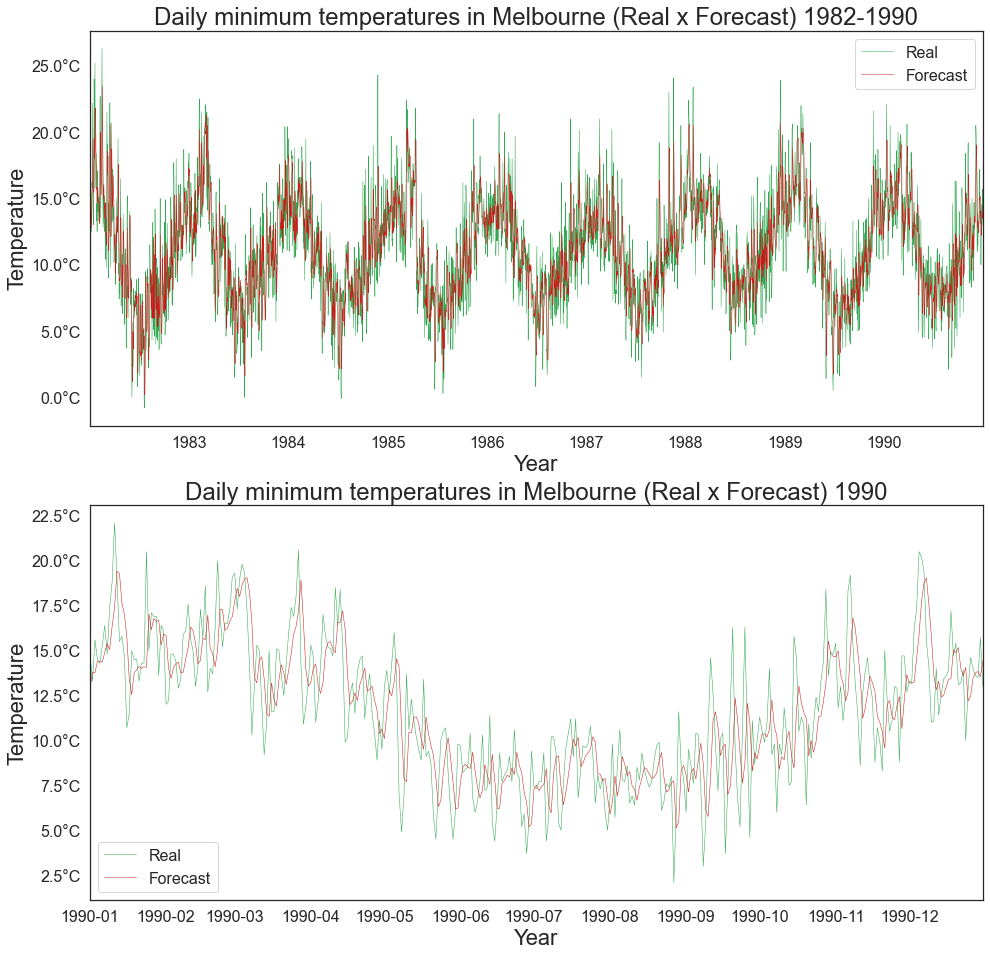

In [253]:
#Vizualizing the forecast 

fig, (ax1,ax2) = plt.subplots(2,1,figsize=(16,16))

sns.lineplot(x=hot_winters_forecast.index,
             y=hot_winters_forecast.daily_min_temp,
            color ='#32a852',lw =0.5,ax = ax1)

sns.lineplot(x=hot_winters_forecast.index,
             y=hot_winters_forecast.forecast,
            color ='#cf1919',lw =0.5,ax = ax1)

ax1.set_title("Daily minimum temperatures in Melbourne (Real x Forecast) 1982-1990",fontsize = 24)
ax1.set_xlabel('Year',fontsize = 22) #caracteristica das labels 
ax1.set_ylabel('Temperature',fontsize = 22)
ax1.yaxis.set_major_formatter(FuncFormatter(celsius_formatter))
ax1.legend(['Real','Forecast'],fontsize =16)

#################fig 2

hot_winters_forecast_1990 = hot_winters_forecast[hot_winters_forecast.index.year ==1990]

sns.lineplot(x=hot_winters_forecast_1990.index,
             y=hot_winters_forecast_1990.daily_min_temp,
            color ='#32a852',lw =0.5,ax = ax2)

sns.lineplot(x=hot_winters_forecast_1990.index,
             y=hot_winters_forecast_1990.forecast,
            color ='#cf1919',lw =0.5,ax = ax2)

ax2.set_title("Daily minimum temperatures in Melbourne (Real x Forecast) 1990",fontsize = 24)
ax2.set_xlabel('Year',fontsize = 22) #caracteristica das labels 
ax2.set_ylabel('Temperature',fontsize = 22)
ax2.yaxis.set_major_formatter(FuncFormatter(celsius_formatter))
ax2.legend(['Real','Forecast'],fontsize =16)

plt.show()

In [223]:
#hot_winters_forecast

hot_winters_metrics = metrics(hot_winters_forecast.daily_min_temp,hot_winters_forecast.forecast,'Hot Winters seasonal')

hot_winters_metrics

,Bias,MAE,RMSE
Model,,,
Hot Winters seasonal,-0.002255,2.061286,2.636054


In [224]:
# Appending the results to our baseline for comparation

metrics_df = pd.concat([hot_winters_metrics,naive_metrics])
metrics_df

,Bias,MAE,RMSE
Model,,,
Hot Winters seasonal,-0.002255,2.061286,2.636054
naïve,-0.002110,2.133817,2.731584


As we stated before, the naïve method is a good option for this situation and, not coincidentally, it obtained good results. 

Even so, applying the hot-winter model, that considers seasonality, we observed an improvement in the metrics that represent a more accurate forecast, while still maintained a practically null bias.

However, the metrics are very similar, and if we look at the visualizations, especially the one focused on the year 1990, we can understand a little better why this occurs. In this graphic, we can clearly see that the model captured a lot of residue (the forecast looks like a shadow of the previous value) indicating that the model is strongly influenced by the previous value, and was not able to fully capture seasonality.